In [1]:
#python modules
import numpy as np
import glob
import pickle
from netCDF4 import Dataset
import folium
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import base64
from folium.element import IFrame

In [1]:
#local modules
from point_history import getmes
from get_point_map import get
from get_point_history import pget


In [32]:
import itertools

In [2]:
%matplotlib notebook

In [3]:
path='tmp/'

In [4]:
# check contents of folder
tfolder = glob.glob(path+'*')
tfolder

['tmp/tmp.pkl', 'tmp/png', 'tmp/20170212.00']

In [5]:
# exclude pkl file from contents of folder
tfolder = [t for t in tfolder if '.pkl' not in t]
tfolder
tfolder = [t for t in tfolder if 'png' not in t]
tfolder

['tmp/20170212.00']

In [6]:
tl = [t.split('/')[1] for t in tfolder]

In [7]:
calc_dir=path+tl[0]+'/' # define project folder, usually the first time stamp folder

In [8]:
pfile = glob.glob(path+'*.pkl')[0]
pfile

'tmp/tmp.pkl'

In [9]:
# read pref file
with open(pfile, 'r') as f:
    dic=pickle.load(f)

In [10]:
basename=dic['bname']

In [11]:
#read obs points dictionary
with open(calc_dir+basename+'.pkl', 'r') as f:
    ptr=pickle.load(f)

### read grid 

In [12]:
d=Dataset(calc_dir+'trim-'+basename+'.nc')

In [13]:
xg=d['XCOR'][:] #grid points
yg=d['YCOR'][:]

In [14]:
xz=d['XZ'][:] #
yz=d['YZ'][:]

## Define map coordinates

In [15]:
#center of lat/lon window
plat = yz.mean()
plon = xz.mean()

In [16]:
mapa = folium.Map(location=[plat, plon], zoom_start=4)

In [17]:
#%%skip
folium.LatLngPopup().add_to(mapa) # click to show lat lon

In [18]:
%%skip
a=np.arange(xg.shape[0])
b=np.arange(xg.shape[1])
glist=[]
for r in itertools.product(a,b): glist.append([r[0],r[1]])
#glist

In [19]:
#draw horizontal lines of grid
for k in xrange(xg.shape[0]):
    try:
        xgrid=zip(yg[k,:],xg[k,:])
        ygrid=zip(yg[k,:],xg[k,:])
        folium.PolyLine(xgrid,weight=.5, color='black').add_to(mapa)
        folium.PolyLine(ygrid,weight=.5, color='black').add_to(mapa)
    except Exception as e:
        print e
        pass

In [20]:
#draw vertical
for k in xrange(xg.shape[1]):
    try:
        xgrid=zip(yg[:,k],xg[:,k])
        ygrid=zip(yg[:,k],xg[:,k])
        folium.PolyLine(xgrid,weight=.5, color='black').add_to(mapa)
        folium.PolyLine(ygrid,weight=.5, color='black').add_to(mapa)
    except Exception as e:
        print e
        pass

In [21]:
%%skip
for k,l in glist:
# draw grid points        
  folium.CircleMarker([yg[k,l],xg[k,l]], popup='{},{}'.format(k,l), radius=50).add_to(mapa)
# draw staggered pressure points
  folium.CircleMarker([yz[k,l],xz[k,l]], popup='{},{}'.format(k,l), radius=50, fill_color='red').add_to(mapa)


In [22]:
mapa

## obs points

In [23]:
df = pd.read_csv('../src/SeaLevelBuoys2.csv', encoding = 'utf8')

In [24]:
df.head()

,ID,lat,lon,name,status,COUNTRY
0,10,48.86000,-175.6000,"Station 46413 - East of ADAK, AK",active,NaN
1,11,49.63000,-169.8700,Station 46408 - NW Pacific S AK,active,NaN
2,12,49.63000,-169.8700,Station 46408 - NW Pacific S AK,active,NaN
3,13,-19.55000,-74.8100,Station 32401 - 260 NM West-Southwest of Arica...,active,NaN
4,14,-18.13419,178.4236,"Suva, Viti Levu, Fiji",active,NaN


In [25]:
df['jref'] = [ptr[i] if i in ptr.keys() else np.nan for i in df.ID.values]

In [26]:
df.head()

,ID,lat,lon,name,status,COUNTRY,jref
0,10,48.86000,-175.6000,"Station 46413 - East of ADAK, AK",active,NaN,NaN
1,11,49.63000,-169.8700,Station 46408 - NW Pacific S AK,active,NaN,NaN
2,12,49.63000,-169.8700,Station 46408 - NW Pacific S AK,active,NaN,NaN
3,13,-19.55000,-74.8100,Station 32401 - 260 NM West-Southwest of Arica...,active,NaN,NaN
4,14,-18.13419,178.4236,"Suva, Viti Levu, Fiji",active,NaN,NaN


In [27]:
#drop the not relevant locations
df = df.dropna(subset=['jref'])
df.jref = df.jref.apply(pd.to_numeric) #convert to integer

In [28]:
df = df.reset_index(drop=True) #reset the index

In [33]:
mapa = folium.Map(location=[plat, plon], zoom_start=4) # reset map

In [34]:
## put on the map

In [35]:
mc = folium.MarkerCluster().add_to(mapa)

In [36]:
for idx, v in df.iterrows():
    folium.Marker([v.lat,v.lon], popup=v['name']).add_to(mc)


In [37]:
mapa

## overlay obs point data

In [43]:
#read netcdf
h=Dataset(calc_dir+'trih-'+basename+'.nc')

In [44]:
ha = h['ZWL'][:]
t = h['time'][:]

In [45]:
idate=datetime.datetime.strptime(tl[0],'%Y%m%d.%H' )

In [46]:
#construct datetime
tw=[]
for it in t:
        tw.append(idate+datetime.timedelta(seconds=np.int(it)))
ttw=[(item-t[0])/60. for item in t]


In [47]:
resolution, width, height = 75, 8, 4

In [48]:
gdic={'time':tw,'ha':ha[:,df.iloc[0].jref.astype(int)]}

In [49]:
gf = pd.DataFrame(gdic)

In [50]:
gf.time = gf.time.apply(pd.to_datetime) #convert to datetime
gf = gf.set_index('time')

In [51]:
#create a graph, choose a station
station = df.iloc[0]['name']
station

u'Faial Island'

<IPython.core.display.Javascript object>


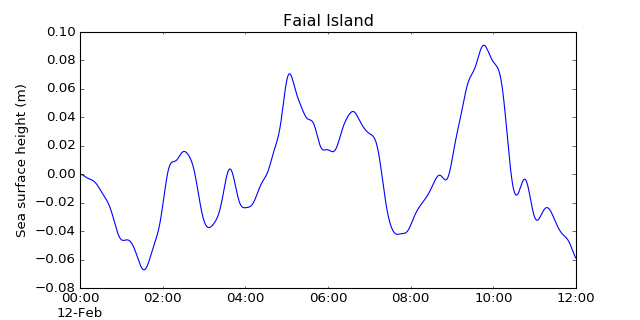

In [52]:
fig, ax = plt.subplots(figsize=(width, height))
ax = gf.plot(ax = ax, legend=False)
ax.set_ylabel('Sea surface height (m)')
ax.set_title(station)
png = 'tmp/png/mpld3_{}.png'.format(station)
fig.savefig(png, dpi=resolution)

encoded = base64.b64encode(open(png, 'rb').read())

In [53]:
mapa = folium.Map(location=[plat, plon], zoom_start=4) # reset map

In [53]:

html = '<img src="data:image/png;base64,{}">'.format
iframe = IFrame(html(encoded), width=(width*resolution)+20, height=(height*resolution)+20)
popup = folium.Popup(iframe, max_width=2650)

icon = folium.Icon(color="red", icon="ok")
marker = folium.Marker(location=[df.iloc[0].lat, df.iloc[0].lon], popup=popup, icon=icon)
mapa.add_children(marker);

In [54]:
mapa